In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


**Importing libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
from sklearn.model_selection import GridSearchCV


#Preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
#from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold


#over sample
from imblearn.over_sampling import SMOTE

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

#Measuring
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix

# Data Overview


Context
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Attribute Information
1) id: unique identifier

2) gender: "Male", "Female" or "Other"

3) age: age of the patient

4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) ever_married: "No" or "Yes"


7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"

9) avg_glucose_level: average glucose level in blood

10) bmi: body mass index

11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

**Import dataset**

In [3]:
df=pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**Lets drop a 'id' column prior to data analysis** 

In [4]:
df=df.drop(["id"],axis=1)
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

**EDA**

1.Lets check the distibution of data to each category in categorical columns to understand its distibution.

2.Plot histogram for all the columns, color coded to stroke to check their distribution of each column data and to analyse how many of those have a stroke and no stroke.

3.Boxplot the numerical coumns to check their distribution and to check if there is any outliers.

4.Check for missing values

In [5]:
for a in ['gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type','smoking_status',"stroke"]:
    print(40*"+++")
    print(df[a].value_counts(normalize=True))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0    0.902544
1    0.097456
Name: hypertension, dtype: float64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0    0.945988
1    0.054012
Name: heart_disease, dtype: float64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Yes    0.656164
No     0.343836
Name: ever_married, dtype: float64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worke

The data above explorations shows that the given dataset is an imbalance dataset with 95 % of the test subjects belonging to class 0, since the datset is imbalance,

Using **accuracy** as a performance metrics in this binary classification will result in poor predictions as accuracy will be over 95 % if model simply outputs as the prediction to be of class 0 (No stroke).

Using Presision/Recall with a good auc curve will give us a realistic performance measure,Since the prediction has implication on the survival of the patient, its good to select a model which will have a highest recall,
Thus Recall will be used as a performance metrics

In [6]:
fig1=px.histogram(df,x="stroke",color="stroke")
#fig1.update_layout(bargap=0.1,showlegend=False)

fig2=px.histogram(df,x="gender",color="gender")
#fig2.update_layout(bargap=0.1,showlegend=False)

fig3=px.histogram(df,x="age",color="gender",)

fig4=px.histogram(df,x="age",color="stroke",)

fig5=px.histogram(df,x="hypertension",color="hypertension",)

fig6=px.histogram(df,x="hypertension",color="stroke",)

fig7=px.histogram(df,x="heart_disease",color="stroke",)

fig8=px.histogram(df,x="ever_married",color="stroke",)

fig9=px.histogram(df,x="work_type",color="stroke",)

fig10=px.histogram(df,x="Residence_type",color="stroke",)

fig11=px.histogram(df,x="smoking_status",color="stroke",)

trace1=[]
trace2=[]
trace3=[]
trace4=[]
trace5=[]
trace6=[]
trace7=[]
trace8=[]
trace9=[]
trace10=[]
trace11=[]

for trace in range(len(fig1["data"])):
    trace1.append(fig1["data"][trace])
    
for trace in range(len(fig2["data"])):
    trace2.append(fig2["data"][trace])
    
for trace in range(len(fig3["data"])):
    trace3.append(fig3["data"][trace])
    
for trace in range(len(fig4["data"])):
    trace4.append(fig4["data"][trace])

for trace in range(len(fig5["data"])):
    trace5.append(fig5["data"][trace])
    
for trace in range(len(fig6["data"])):
    trace6.append(fig6["data"][trace])

    
for trace in range(len(fig7["data"])):
    trace7.append(fig7["data"][trace])

for trace in range(len(fig8["data"])):
    trace8.append(fig8["data"][trace])
    
for trace in range(len(fig9["data"])):
    trace9.append(fig9["data"][trace])    
    
for trace in range(len(fig10["data"])):
    trace10.append(fig10["data"][trace])   
    
for trace in range(len(fig11["data"])):
    trace11.append(fig11["data"][trace])
    
this_figure = sp.make_subplots(rows=6, cols=2) 

for traces in trace1:
    this_figure.append_trace(traces, row=1, col=1)
for traces in trace2:
    this_figure.append_trace(traces, row=1, col=2)
for traces in trace3:
    this_figure.append_trace(traces, row=2, col=1)
for traces in trace4:
    this_figure.append_trace(traces, row=2, col=2)
for traces in trace5:
    this_figure.append_trace(traces, row=3, col=1)
for traces in trace6:
    this_figure.append_trace(traces, row=3, col=2)
for traces in trace7:
    this_figure.append_trace(traces, row=4, col=1)
for traces in trace8:
    this_figure.append_trace(traces, row=4, col=2)
for traces in trace9:
    this_figure.append_trace(traces, row=5, col=1)
for traces in trace10:
    this_figure.append_trace(traces, row=5, col=2)
for traces in trace11:
    this_figure.append_trace(traces, row=6, col=1)
    
    
this_figure.update_layout(bargap=0.1,showlegend=True,height=1700,width=1000)


this_figure.update_xaxes(title_text="stroke", row=1, col=1)
this_figure.update_xaxes(title_text="gender", row=1, col=2)
this_figure.update_xaxes(title_text="age and gender", row=2, col=1)
this_figure.update_xaxes(title_text="age and stroke", row=2, col=2)
this_figure.update_xaxes(title_text="Hypertension", row=3, col=1)
this_figure.update_xaxes(title_text="Hypertension and stroke", row=3, col=2)
this_figure.update_xaxes(title_text="Heat disease", row=4, col=1)
this_figure.update_xaxes(title_text="Ever married", row=4, col=2)
this_figure.update_xaxes(title_text="Work type", row=5, col=1)
this_figure.update_xaxes(title_text="Residence type", row=5, col=2)
this_figure.update_xaxes(title_text="Smoking", row=6, col=1)



this_figure.show()

In [7]:
df[df["gender"]=="Other"]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


**Since its just one entry where gender is other, lets drop it**

In [8]:
df=df.drop(df[df["gender"]=="Other"].index)

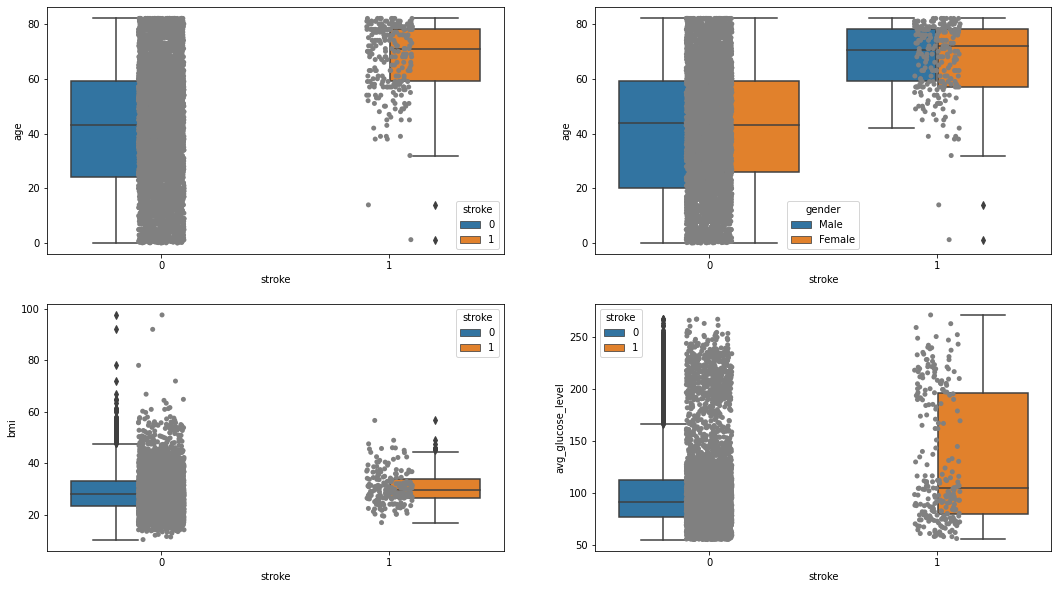

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

sns.boxplot(ax=axes[0,0],x='stroke', y='age',hue="stroke", data=df)
sns.stripplot(ax=axes[0,0],x='stroke', y='age',color="grey", data=df)

sns.boxplot(ax=axes[0,1],x='stroke', y='age',hue="gender", data=df)
sns.stripplot(ax=axes[0,1],x='stroke', y='age',color="grey", data=df)

sns.boxplot(ax=axes[1,0],x='stroke', y='bmi',hue="stroke", data=df)
sns.stripplot(ax=axes[1,0],x='stroke', y='bmi',color="grey", data=df)

sns.boxplot(ax=axes[1,1],x='stroke', y='avg_glucose_level',hue="stroke", data=df)
sns.stripplot(ax=axes[1,1],x='stroke', y='avg_glucose_level',color="grey", data=df)

fig.show()

**Looking at the distribution of age of subjects along with stroke details, the two subjects whose age is below 20 seems to have a stroke and seems to be outliers, lets have a look at it**

In [10]:
df[(df['stroke'] == 1) & (df['age'] < 20)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1


* Lets drop a test subject of age 1.32 as we done have info on bmi
* Test subject who is 14 years ols is not a outliers because the avg. glucose level and the bmi of the subject is clearly outside the acceptable range and thus retain it

In [11]:
df=df.drop(df[(df["stroke"]==1)& (df["age"]<10)].index)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5108 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5108 non-null   object 
 1   age                5108 non-null   float64
 2   hypertension       5108 non-null   int64  
 3   heart_disease      5108 non-null   int64  
 4   ever_married       5108 non-null   object 
 5   work_type          5108 non-null   object 
 6   Residence_type     5108 non-null   object 
 7   avg_glucose_level  5108 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5108 non-null   object 
 10  stroke             5108 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 478.9+ KB


In [13]:
(df["bmi"].isna().sum()/len(df))*100

3.915426781519186

# Handling missing values values
* We can either drop all the rows with missing bmi values or we can impute them, during inital trials I found the performance to be slightly better when missing values were imputed 
* Since the inferences drawn from the bmi is different for the test subjects belonging to different age group and gender, it makws more sense to imoute the issing values considering the nieghbopuring data points, thus I'll be using the **KNNimputer** to impute the missing values

# Preprocessing the data
* Numerical columns to be scaled using StandardScaler
* Missing numerical values to be imputed using KNNIMPUTER
* One Hot encode all the categorical columns other than "hypertenion" and "heart_disease".

In [14]:
X=df.drop(["stroke"],axis=1)
y=df["stroke"]


In [15]:
scaler=StandardScaler()
imputer= KNNImputer(n_neighbors=5)
imputer_cat=SimpleImputer(strategy='constant')
one_hot_encoder=OneHotEncoder(handle_unknown='ignore')
over_sampling=SMOTE(random_state=42)

numercial_cols=['age', 'bmi', 'avg_glucose_level']
catergorical_cols=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

data_prep=make_column_transformer((make_pipeline(scaler,imputer), numercial_cols),
                                  (make_pipeline(imputer_cat, one_hot_encoder), catergorical_cols),
                                  remainder="passthrough")

# Correlation
Correlation gives us better idea about which parametrs influence the possibility of **stroke** the most, in case we need to speed us the process, we can drop the columns which has least correlation with **stroke** parameter


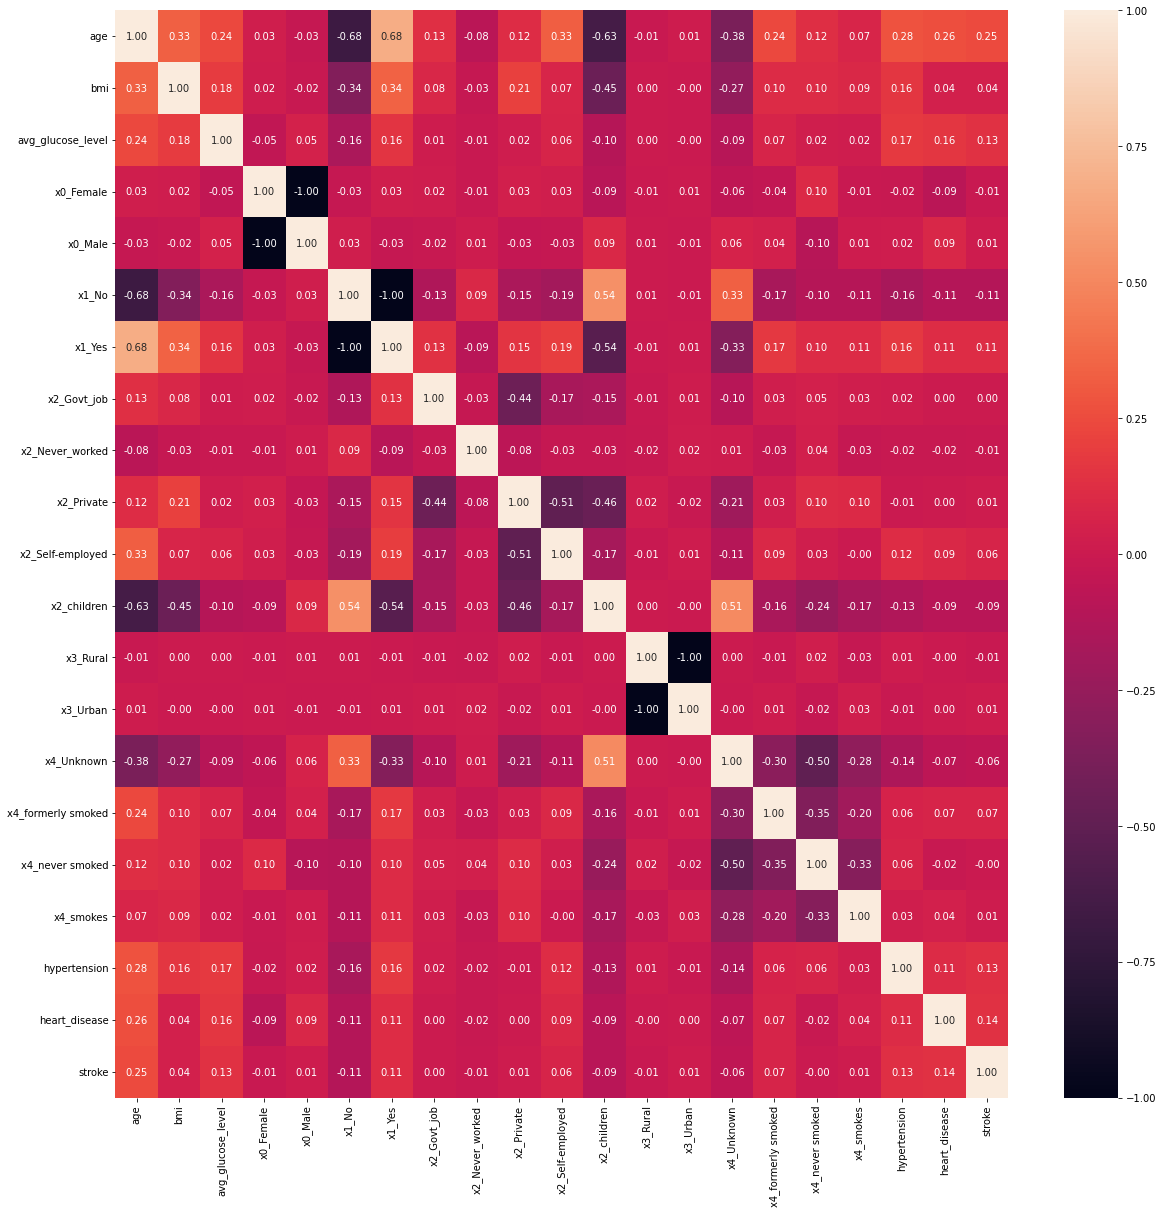

In [16]:
df_temp=df
non_processed_cols=['hypertension','heart_disease',"stroke"]
data_prep_temp=make_column_transformer((make_pipeline(scaler,imputer), numercial_cols),
                                  (make_pipeline(imputer_cat, one_hot_encoder), catergorical_cols),
                                  remainder="passthrough")
processed=data_prep_temp.fit_transform(df_temp)
final_columns=numercial_cols+data_prep_temp.named_transformers_["pipeline-2"]['onehotencoder'].get_feature_names().tolist()+non_processed_cols
data_temp=pd.DataFrame(processed,columns=final_columns)
plt.figure(figsize=(20,20))
sns.heatmap(data_temp.corr(), annot=True, fmt='.2f')
plt.show()


**Loosely correlated parameters can be dropped off if the training time is high or incase the model is getting overfitted**

# Training models
* Logistic Regression
* Naive Bayes
* Decision Tree
* Random Forest Classifier
* Gradient Boosting Classifier
* Stochastic Gradient Descent Classifier
* Support Vector Machine
* K Nearest classifier

1. Cross validate the models in its default settings (Since the dataset is unbalanced, lets keeep the **class weight ="balanced"**)

2. Ensemble the top 4 models (Top 4 models and hyper parameter tuned top 4 models)

3. Slect the model with best performance (Ensemble of top 4 default models vs Ensemble of top 2 hyper parameter tuned models vs Hyper parameter tuned models)


In [17]:
models={"Logistic Regression" : LogisticRegression(random_state=42, max_iter=500, class_weight='balanced'),
           "Naive Bayes": GaussianNB(),
            'Decison Tree':DecisionTreeClassifier(random_state=42, class_weight='balanced'),
            'Random Forest Classifier': RandomForestClassifier(random_state=42, class_weight='balanced'),
            'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
            'Stochastic Grad Descent':SGDClassifier(random_state=42, class_weight='balanced'),
            'Support Vector Machine':SVC(random_state=42, class_weight='balanced'),
            'K Nearest Classifier':KNeighborsClassifier()
           }

models_name=[]
validation_accuracy=[]
validation_precision=[]
validation_recall=[]
validation_f1=[]
validation_roc_auc=[]

for model,classifier in models.items():
    print("Validating ",model)
    
    pipeline=make_pipeline(data_prep,over_sampling,classifier)
    
    
    
    validation_score= cross_validate(pipeline,X,y,cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
                                    scoring=("accuracy","precision","recall","f1","roc_auc"),n_jobs=-1)
    
    models_name.append(model)
    validation_accuracy.append(validation_score["test_accuracy"].mean())
    validation_precision.append(validation_score["test_precision"].mean())
    validation_recall.append(validation_score["test_recall"].mean())
    validation_f1.append(validation_score["test_f1"].mean())
    validation_roc_auc.append(validation_score["test_roc_auc"].mean())
    
    
    Validation_results=pd.DataFrame({
        "Model":models_name,
        "Validation_accuracy":validation_accuracy,
        "Validation_precision":validation_precision,
        "Validation_recall":validation_recall,
        "Validation_f1_score":validation_f1,
        "Validation_roc_auc":validation_roc_auc
    })
    
print("Validation Complete")

Validating  Logistic Regression
Validating  Naive Bayes
Validating  Decison Tree
Validating  Random Forest Classifier
Validating  Gradient Boosting Classifier
Validating  Stochastic Grad Descent
Validating  Support Vector Machine
Validating  K Nearest Classifier
Validation Complete


In [18]:
Validation_results

,Model,Validation_accuracy,Validation_precision,Validation_recall,Validation_f1_score,Validation_roc_auc
0,Logistic Regression,0.744318,0.134162,0.781088,0.228875,0.839138
1,Naive Bayes,0.354862,0.067855,0.962449,0.126752,0.789092
2,Decison Tree,0.879601,0.110164,0.212381,0.144441,0.563015
3,Random Forest Classifier,0.925542,0.118710,0.084626,0.097544,0.782604
4,Gradient Boosting Classifier,0.874770,0.162839,0.377878,0.227304,0.797221
5,Stochastic Grad Descent,0.737538,0.129292,0.749932,0.219573,0.834431
6,Support Vector Machine,0.810885,0.123683,0.477388,0.196292,0.776221
7,K Nearest Classifier,0.830527,0.107219,0.338830,0.162699,0.648793


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

for model,classifier in models.items():
    print("Testing ",model)
    pipeline=make_pipeline(data_prep,over_sampling,classifier)
    pipeline.fit(X_train,y_train)
    predictions = pipeline.predict(X_test)
    print(classification_report(y_test, predictions))
    print(40*"+++")

Testing  Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1459
           1       0.13      0.72      0.21        74

    accuracy                           0.75      1533
   macro avg       0.55      0.73      0.53      1533
weighted avg       0.94      0.75      0.82      1533

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing  Naive Bayes
              precision    recall  f1-score   support

           0       1.00      0.28      0.44      1459
           1       0.07      0.99      0.12        74

    accuracy                           0.32      1533
   macro avg       0.53      0.64      0.28      1533
weighted avg       0.95      0.32      0.43      1533

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing  Decison Tree
              precision    recal

**ROC AUC CURVE**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing  Logistic Regression


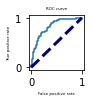

Auc :  0.82484300613156
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing  Naive Bayes


<Figure size 432x288 with 0 Axes>

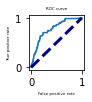

Auc :  0.7732110108737936
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing  Decison Tree


<Figure size 432x288 with 0 Axes>

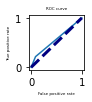

Auc :  0.5645851471759628
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing  Random Forest Classifier


<Figure size 432x288 with 0 Axes>

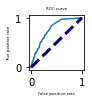

Auc :  0.7702749013578349
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing  Gradient Boosting Classifier


<Figure size 432x288 with 0 Axes>

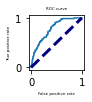

Auc :  0.7752764759276068
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing  Stochastic Grad Descent


<Figure size 432x288 with 0 Axes>

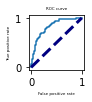

Auc :  0.8275012503936424
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing  Support Vector Machine


<Figure size 432x288 with 0 Axes>

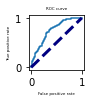

Auc :  0.7457532927032584
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing  K Nearest Classifier


<Figure size 432x288 with 0 Axes>

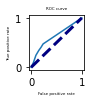

Auc :  0.6241640886945891


<Figure size 432x288 with 0 Axes>

In [20]:
models_altered={"Logistic Regression" : LogisticRegression(random_state=42, max_iter=500, class_weight='balanced'),
           "Naive Bayes": GaussianNB(),
            'Decison Tree':DecisionTreeClassifier(random_state=42, class_weight='balanced'),
            'Random Forest Classifier': RandomForestClassifier(random_state=42, class_weight='balanced'),
            'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
            'Stochastic Grad Descent':SGDClassifier(random_state=42, class_weight='balanced',loss="log"),
            'Support Vector Machine':SVC(random_state=42, class_weight='balanced',probability=True),
            'K Nearest Classifier':KNeighborsClassifier()
           }

from sklearn.metrics import roc_curve, auc

for model,classifier in models_altered.items():
    print(40*"+++")
    print("Testing ",model)
    pipeline=make_pipeline(data_prep,over_sampling,classifier)
    pipeline.fit(X_train,y_train)
    
    fpr_lr,tpr_lr,_=roc_curve(y_test,pipeline.predict_proba(X_test)[:,1])

    plt.figure(figsize=(1,1))

    plt.plot(fpr_lr,tpr_lr)
    plt.xlabel("False positive rate",fontsize=4)
    plt.ylabel("True positive rate", fontsize=4)
    plt.title("ROC curve", fontsize=4)
    plt.plot([0,1],[0,1],color="navy",lw=3,linestyle="--")
    plt.show()

    sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    print("Auc : ", auc(fpr_lr, tpr_lr))

**Top 4 models**

1. Logistic regression

2. Stochastic Gradient Descent Classifier

3. Gradient Boosting Classifier

4. Support Vector Machine



**Ensemble of top 4 model**

In [21]:
log_pipeline_basic=make_pipeline(data_prep, over_sampling, LogisticRegression(max_iter=500))
sgd_pipeline_basic=pipeline = make_pipeline(data_prep, over_sampling, SGDClassifier(random_state=42, class_weight='balanced', max_iter=10000,loss="log"))
gd_pipeline_basic=make_pipeline(data_prep, over_sampling, GradientBoostingClassifier(random_state=42))
svc_pipeline_basic=make_pipeline(data_prep, over_sampling, SVC(random_state=42, class_weight='balanced',probability=True))

voting_clf_basic = VotingClassifier(
estimators=[('lr_basic', log_pipeline_basic), ('sgd_basic', sgd_pipeline_basic)],
voting='soft'
)

validation_score_ensemble= cross_validate(voting_clf_basic,X,y,cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
                                    scoring=("accuracy","precision","recall","f1","roc_auc"),n_jobs=-1)


In [22]:
Validation_ensemble_results={
        "Validation_accuracy":validation_score_ensemble["test_accuracy"].mean(),
        "Validation_precision":validation_score_ensemble["test_precision"].mean(),
        "Validation_recall":validation_score_ensemble["test_recall"].mean(),
        "Validation_f1_score":validation_score_ensemble["test_f1"].mean(),
        "Validation_roc_auc":validation_score_ensemble["test_roc_auc"].mean()
    }
Validation_ensemble_results

{'Validation_accuracy': 0.7325697853235993,
 'Validation_precision': 0.13077206501479952,
 'Validation_recall': 0.7959183673469389,
 'Validation_f1_score': 0.22444935631658355,
 'Validation_roc_auc': 0.8383857394809777}

In [23]:
voting_clf_basic.fit(X_train,y_train)
predictions_1 = voting_clf_basic.predict(X_test)
print(classification_report(y_test, predictions_1))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1459
           1       0.12      0.72      0.21        74

    accuracy                           0.73      1533
   macro avg       0.55      0.73      0.52      1533
weighted avg       0.94      0.73      0.81      1533



Auc :  0.826454624604042


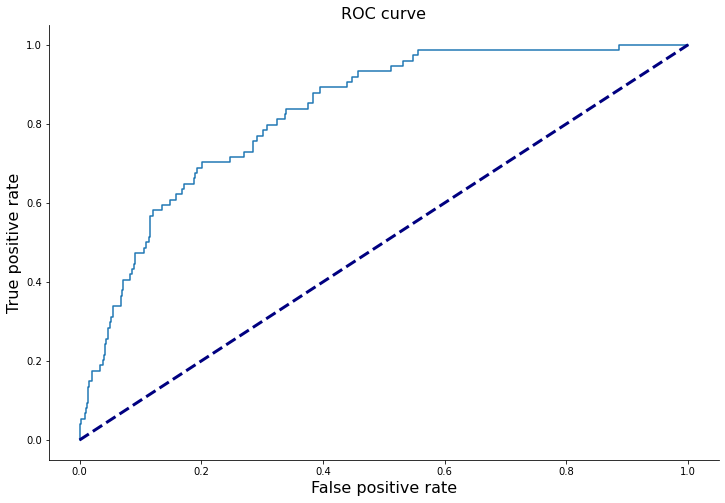

In [24]:
from sklearn.metrics import roc_curve, auc

fpr_lr,tpr_lr,_=roc_curve(y_test,voting_clf_basic.predict_proba(X_test)[:,1])

plt.figure(figsize=(12,8))

plt.plot(fpr_lr,tpr_lr)
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate", fontsize=16)
plt.title("ROC curve", fontsize=16)
plt.plot([0,1],[0,1],color="navy",lw=3,linestyle="--")

sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
print("Auc : ", auc(fpr_lr, tpr_lr))

**Hyper parameter tuning**

1.Logistic regression

In [25]:
pipeline1 = make_pipeline(data_prep, over_sampling, LogisticRegression(max_iter=500))
params_log = {}
params_log['logisticregression__C'] = [100, 10, 1.0, 0.1, 0.01]
params_log['logisticregression__penalty'] = ['l2']
params_log['logisticregression__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
grid = GridSearchCV(pipeline1,params_log , cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring='recall', n_jobs=-1)
grid_result = grid.fit(X, y)
grid.best_score_

0.7985034013605443

In [26]:
grid.best_params_

{'logisticregression__C': 0.01,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

In [27]:
df_grid=pd.DataFrame(grid.cv_results_)[['params',"mean_test_score","rank_test_score"]]
pd.set_option('display.max_colwidth', None)
df_grid.sort_values("rank_test_score").head(5)

,params,mean_test_score,rank_test_score
14,"{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}",0.798503,1
12,"{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}",0.793116,2
13,"{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}",0.793116,2
11,"{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}",0.780980,4
9,"{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}",0.778259,5


2. Stochastic Gradient Descent Classifier

In [28]:
pipeline2 = make_pipeline(data_prep, over_sampling, SGDClassifier(random_state=42, class_weight='balanced', max_iter=10000))
params_sgd={
    "sgdclassifier__loss":["hinge","log","squared_hinge","modified_huber"],
    "sgdclassifier__alpha":[.0001,.001,.01,.1],
    "sgdclassifier__penalty":["l2","l1","none"]
}
grid = GridSearchCV(pipeline2,params_sgd , cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring='recall', n_jobs=-1)
grid_result = grid.fit(X, y)
grid.best_score_

0.8682721088435374

In [29]:
grid.best_params_

{'sgdclassifier__alpha': 0.1,
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__penalty': 'l1'}

In [30]:
df_grid_sgd=pd.DataFrame(grid.cv_results_)[['params',"mean_test_score","rank_test_score"]]
pd.set_option('display.max_colwidth', None)
df_grid_sgd.sort_values("rank_test_score").head(5)

,params,mean_test_score,rank_test_score
37,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l1'}",0.868272,1
36,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'}",0.849497,2
40,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__loss': 'log', 'sgdclassifier__penalty': 'l1'}",0.835918,3
46,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__loss': 'modified_huber', 'sgdclassifier__penalty': 'l1'}",0.829306,4
25,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l1'}",0.826585,5


3. Gradient Boosting Classifier

In [31]:
pipeline3 = make_pipeline(data_prep, over_sampling, GradientBoostingClassifier(random_state=42))
params_gb={
    "gradientboostingclassifier__loss":["deviance", "exponential"],
    "gradientboostingclassifier__learning_rate":[.001,.01,.1,1,10,100],
    "gradientboostingclassifier__n_estimators":[100,150,250],
    
}
grid = GridSearchCV(pipeline3,params_gb , cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring='recall', n_jobs=-1)
grid_result = grid.fit(X, y)
grid.best_score_

0.841904761904762

In [32]:
grid.best_params_

{'gradientboostingclassifier__learning_rate': 100,
 'gradientboostingclassifier__loss': 'exponential',
 'gradientboostingclassifier__n_estimators': 250}

In [33]:
pd.set_option('display.max_colwidth', None)
df_grid_gb=pd.DataFrame(grid.cv_results_)[['params',"mean_test_score","rank_test_score"]]
df_grid_gb.sort_values("rank_test_score").head(5)

,params,mean_test_score,rank_test_score
35,"{'gradientboostingclassifier__learning_rate': 100, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__n_estimators': 250}",0.841905,1
33,"{'gradientboostingclassifier__learning_rate': 100, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__n_estimators': 100}",0.793905,2
34,"{'gradientboostingclassifier__learning_rate': 100, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__n_estimators': 150}",0.793905,2
2,"{'gradientboostingclassifier__learning_rate': 0.001, 'gradientboostingclassifier__loss': 'deviance', 'gradientboostingclassifier__n_estimators': 250}",0.782286,4
5,"{'gradientboostingclassifier__learning_rate': 0.001, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__n_estimators': 250}",0.782286,4


4. Support Vector Machine

In [34]:
pipeline4 = make_pipeline(data_prep, over_sampling, SVC(random_state=42, class_weight='balanced',probability=True))
params_svc={
    "svc__kernel":['poly', 'rbf', 'sigmoid'],
    "svc__degree":[2,3,4],
    "svc__gamma":['scale','auto']}
grid = GridSearchCV(pipeline4,params_svc , cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring='recall', n_jobs=-1)
grid_result = grid.fit(X, y)
grid.best_score_

0.7542312925170068

In [35]:
grid.best_params_

{'svc__degree': 2, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}

In [36]:
df_grid_svc=pd.DataFrame(grid.cv_results_)[['params',"mean_test_score","rank_test_score"]]
df_grid_svc.sort_values("rank_test_score").head(5)

,params,mean_test_score,rank_test_score
3,"{'svc__degree': 2, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",0.754231,1
4,"{'svc__degree': 2, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",0.727347,2
10,"{'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",0.727347,2
16,"{'svc__degree': 4, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",0.727347,2
17,"{'svc__degree': 4, 'svc__gamma': 'auto', 'svc__kernel': 'sigmoid'}",0.713687,5


**Tuned models with processing pipeline**

In [37]:
logreg_pipeline = make_pipeline(data_prep, over_sampling,LogisticRegression(C=0.01, penalty='l2', solver='liblinear', max_iter=500))
sgd_pipeline_1 = make_pipeline(data_prep, over_sampling,SGDClassifier(random_state=42, class_weight='balanced', 
                  max_iter=10000,alpha=0.1, loss='log',penalty='l1'))
sgd_pipeline = make_pipeline(data_prep, over_sampling,SGDClassifier(random_state=42, class_weight='balanced', 
                  max_iter=10000,alpha=0.1, loss='hinge',penalty='l1'))
gb_pipeline = make_pipeline(data_prep, over_sampling,GradientBoostingClassifier(random_state=42,learning_rate=0.1,loss='deviance',n_estimators=250))

svc_pipeline=make_pipeline(data_prep, over_sampling, SVC(random_state=42, class_weight='balanced',probability=True,kernel="poly",gamma='auto',degree=2))

**Ensemble of top 2 tuned models**

In [38]:
voting_clf_tuned = VotingClassifier(
estimators=[('lor_reg', logreg_pipeline), ('sgd', sgd_pipeline_1),],
voting='soft'
)
validation_score_ensemble= cross_validate(voting_clf_tuned,X,y,cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
                                    scoring=("accuracy","precision","recall","f1","roc_auc"),n_jobs=-1)


In [39]:
Validation_ensemble_results={
        "Validation_accuracy":validation_score_ensemble["test_accuracy"].mean(),
        "Validation_precision":validation_score_ensemble["test_precision"].mean(),
        "Validation_recall":validation_score_ensemble["test_recall"].mean(),
        "Validation_f1_score":validation_score_ensemble["test_f1"].mean(),
        "Validation_roc_auc":validation_score_ensemble["test_roc_auc"].mean()
    }
Validation_ensemble_results

{'Validation_accuracy': 0.7241563181026238,
 'Validation_precision': 0.1280350882304224,
 'Validation_recall': 0.8052789115646259,
 'Validation_f1_score': 0.22089023498854482,
 'Validation_roc_auc': 0.8420044231684443}

In [40]:
voting_clf_tuned.fit(X_train,y_train)
predictions_2 = voting_clf_tuned.predict(X_test)
print(classification_report(y_test, predictions_2))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      1459
           1       0.12      0.76      0.21        74

    accuracy                           0.72      1533
   macro avg       0.55      0.74      0.52      1533
weighted avg       0.94      0.72      0.80      1533



Auc :  0.8307615360391234


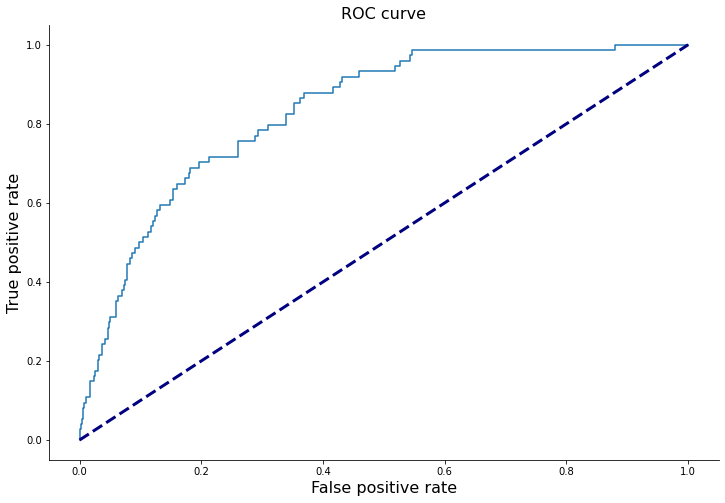

In [41]:
fpr_lr,tpr_lr,_=roc_curve(y_test,voting_clf_tuned.predict_proba(X_test)[:,1])

plt.figure(figsize=(12,8))

plt.plot(fpr_lr,tpr_lr)
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate", fontsize=16)
plt.title("ROC curve", fontsize=16)
plt.plot([0,1],[0,1],color="navy",lw=3,linestyle="--")

sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
print("Auc : ", auc(fpr_lr, tpr_lr))

**Tuned Logistic regression model**

In [42]:
logreg_pipeline.fit(X_train,y_train)
predictions_voting_test = logreg_pipeline.predict(X_test)
print(classification_report(y_test, predictions_voting_test))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1459
           1       0.12      0.76      0.21        74

    accuracy                           0.73      1533
   macro avg       0.55      0.74      0.52      1533
weighted avg       0.94      0.73      0.81      1533



Auc :  0.828019932200878


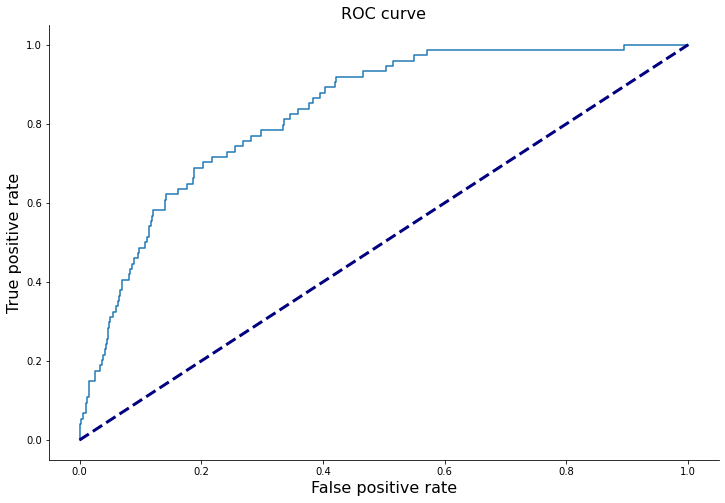

In [43]:
from sklearn.metrics import roc_curve, auc

fpr_lr,tpr_lr,_=roc_curve(y_test,logreg_pipeline.predict_proba(X_test)[:,1])

plt.figure(figsize=(12,8))

plt.plot(fpr_lr,tpr_lr)
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate", fontsize=16)
plt.title("ROC curve", fontsize=16)
plt.plot([0,1],[0,1],color="navy",lw=3,linestyle="--")

sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
print("Auc : ", auc(fpr_lr, tpr_lr))

**Tuned 
Stochastic Gradient Descent Classifier**

In [44]:
sgd_pipeline_1.fit(X_train,y_train)
predictions_voting_test = sgd_pipeline_1.predict(X_test)
print(classification_report(y_test, predictions_voting_test))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1459
           1       0.13      0.81      0.22        74

    accuracy                           0.72      1533
   macro avg       0.56      0.76      0.52      1533
weighted avg       0.95      0.72      0.80      1533



Auc :  0.829538928922068


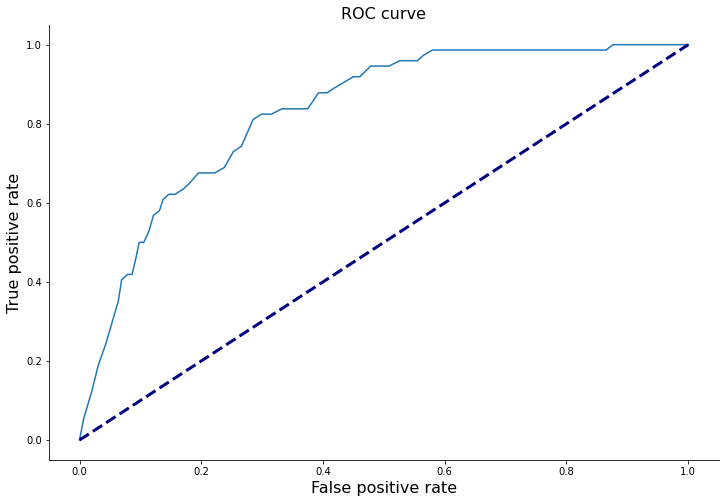

In [45]:
from sklearn.metrics import roc_curve, auc

fpr_lr,tpr_lr,_=roc_curve(y_test,sgd_pipeline_1.predict_proba(X_test)[:,1])

plt.figure(figsize=(12,8))

plt.plot(fpr_lr,tpr_lr)
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate", fontsize=16)
plt.title("ROC curve", fontsize=16)
plt.plot([0,1],[0,1],color="navy",lw=3,linestyle="--")

sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
print("Auc : ", auc(fpr_lr, tpr_lr))

**Gradient Boosting Classifier**

In [46]:
gb_pipeline.fit(X_train,y_train)
predictions_voting_test = gb_pipeline.predict(X_test)
print(classification_report(y_test, predictions_voting_test))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1459
           1       0.20      0.22      0.21        74

    accuracy                           0.92      1533
   macro avg       0.58      0.59      0.58      1533
weighted avg       0.92      0.92      0.92      1533



Auc :  0.7544319507993257


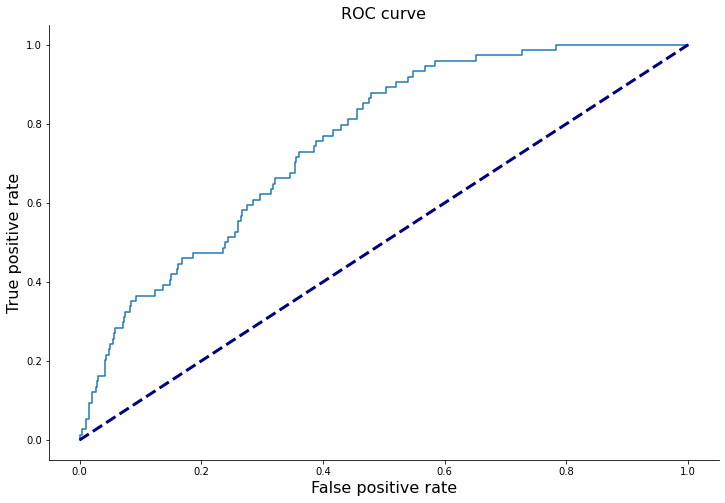

In [47]:
from sklearn.metrics import roc_curve, auc

fpr_lr,tpr_lr,_=roc_curve(y_test,gb_pipeline.predict_proba(X_test)[:,1])

plt.figure(figsize=(12,8))

plt.plot(fpr_lr,tpr_lr)
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate", fontsize=16)
plt.title("ROC curve", fontsize=16)
plt.plot([0,1],[0,1],color="navy",lw=3,linestyle="--")

sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
print("Auc : ", auc(fpr_lr, tpr_lr))

**Tuned Support Vector Machine**

In [48]:
svc_pipeline.fit(X_train,y_train)
predictions_voting_test = svc_pipeline.predict(X_test)
print(classification_report(y_test, predictions_voting_test))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1459
           1       0.12      0.74      0.21        74

    accuracy                           0.74      1533
   macro avg       0.55      0.74      0.53      1533
weighted avg       0.94      0.74      0.81      1533



Auc :  0.8060593149695274


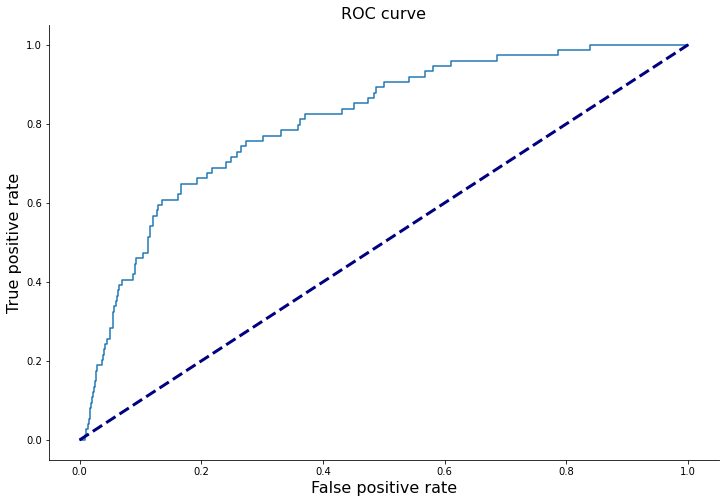

In [49]:
from sklearn.metrics import roc_curve, auc

fpr_lr,tpr_lr,_=roc_curve(y_test,svc_pipeline.predict_proba(X_test)[:,1])

plt.figure(figsize=(12,8))

plt.plot(fpr_lr,tpr_lr)
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate", fontsize=16)
plt.title("ROC curve", fontsize=16)
plt.plot([0,1],[0,1],color="navy",lw=3,linestyle="--")

sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
print("Auc : ", auc(fpr_lr, tpr_lr))

**Verdict**

Comparing the performance of Ensemble of top 4 default models vs Ensemble of top 2 hyper parameter tuned models vs Hyper parameter tuned models.

*SGD, Logistic regression and ensemble has similar ROC AUC value but tuned SGD has better recall on both the classes and thus lets select tuned SGD as final model.

In [50]:
final_model=sgd_pipeline_1
final_model.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('knnimputer',
                                                                   KNNImputer())]),
                                                  ['age', 'bmi',
                                                   'avg_glucose_level']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehotencoder',
                           

**Function to run prediction model**

In [51]:
def stroke_check(Test_subject):
    
    patient_info = pd.DataFrame(Test_subject)

    prediction = final_model.predict_proba(patient_info)

    print(40 * '+++')
    if prediction[0][0] > .50:
        print('There is {} % chance that patient wont have stroke'.format(100 * round(prediction[0][0], 2)))
    else:
        print('There is {} % chance that patient will have stroke'.format(100 * round(prediction[0][1], 2)))
        

    return prediction

**Pateint information must be input in a dictionary whose key should match with the column of input dataset (Excluding the "id" column as we have dropped it initially)**

In [52]:
Test_sub1 = {
    'gender': ['Male'],
    'age': [41.0],
    'hypertension': [0],
    'heart_disease': [0],
    'ever_married': ['Yes'],
    'work_type': ['Private'],
    'Residence_type': ['Urban'],
    'avg_glucose_level': [124.00],
    'bmi': [30.0],
    'smoking_status': ['never smoked']
}


In [53]:
stroke_check(Test_sub1)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
There is 66.0 % chance that patient wont have stroke


array([[0.66033896, 0.33966104]])

In [54]:
Test_sub2 = {
    'gender': ['Female'],
    'age': [71.0],
    'hypertension': [1],
    'heart_disease': [0],
    'ever_married': ['No'],
    'work_type': ['Private'],
    'Residence_type': ['Urban'],
    'avg_glucose_level': [180.00],
    'bmi': [29.0],
    'smoking_status': ['never smoked']
}


In [55]:
stroke_check(Test_sub2)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
There is 65.0 % chance that patient will have stroke


array([[0.34694481, 0.65305519]])

***Thank you for reading.***